## 🚗 Real-Time Dynamic Parking Pricing – Summer Analytics 2025 (Week 6)

This notebook presents a complete pipeline for simulating dynamic pricing in urban parking systems using real-world-like data. We designed three pricing models and integrated a real-time streaming pipeline using [Pathway](https://pathway.com), along with an interactive visualization using Bokeh.


In [2]:
# libraries/packages
!pip install pathway bokeh --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathway as pw
from bokeh.plotting import figure, output_notebook, show
output_notebook()

In [6]:
#Data Loading
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [7]:
import io
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))

In [8]:
from datetime import datetime

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')

In [9]:
# 📊 Feature Engineering

# Occupancy Ratio
df['OccupancyRatio'] = df['Occupancy'] / df['Capacity']

# VehicleType Encoding (assigning weights)
vehicle_type_map = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
df['VehicleTypeWeight'] = df['VehicleType'].map(vehicle_type_map)

# TrafficCondition Encoding (assigning weights)
traffic_map = {'low': 0.3, 'medium': 0.6, 'high': 1.0}
df['TrafficWeight'] = df['TrafficConditionNearby'].map(traffic_map)

# Normalize Queue Length
df['Norm_QueueLength'] = df['QueueLength'] / df['QueueLength'].max()

# No need to normalize OccupancyRatio since it's already 0–1
df['Norm_Occupancy'] = df['OccupancyRatio']

# Final modeling dataframe
df_model = df[[
    'SystemCodeNumber', 'Timestamp', 'Capacity', 'Occupancy',
    'QueueLength', 'OccupancyRatio', 'Norm_Occupancy',
    'Norm_QueueLength', 'IsSpecialDay', 'VehicleTypeWeight',
    'TrafficWeight', 'Latitude', 'Longitude'
]]

# Preview
df_model.head()

,SystemCodeNumber,Timestamp,Capacity,Occupancy,QueueLength,OccupancyRatio,Norm_Occupancy,Norm_QueueLength,IsSpecialDay,VehicleTypeWeight,TrafficWeight,Latitude,Longitude
0,BHMBCCMKT01,2016-10-04 07:59:00,577,61,1,0.105719,0.105719,0.066667,0,1.0,0.3,26.144536,91.736172
1,BHMBCCMKT01,2016-10-04 08:25:00,577,64,1,0.110919,0.110919,0.066667,0,1.0,0.3,26.144536,91.736172
2,BHMBCCMKT01,2016-10-04 08:59:00,577,80,2,0.138648,0.138648,0.133333,0,1.0,0.3,26.144536,91.736172
3,BHMBCCMKT01,2016-10-04 09:32:00,577,107,2,0.185442,0.185442,0.133333,0,1.0,0.3,26.144536,91.736172
4,BHMBCCMKT01,2016-10-04 09:59:00,577,150,2,0.259965,0.259965,0.133333,0,0.5,0.3,26.144536,91.736172


## 📊 Pricing Models Overview

### 🔹 Model 1: Linear Incremental Pricing
A baseline model that increases price linearly with occupancy:

\[
P_{t+1} = P_t + \alpha \cdot \left(\frac{\text{Occupancy}}{\text{Capacity}}\right)
\]

- Simple rule-based mechanism
- Unbounded price growth
- Used as reference

---

### 🔹 Model 2: Demand-Based Pricing
A realistic pricing strategy that computes demand from various features:

\[
\text{DemandScore} = \alpha \cdot \text{OccupancyRatio} + \beta \cdot \text{QueueLength} + \gamma \cdot \text{Traffic} + \delta \cdot \text{SpecialDay} + \epsilon \cdot \text{VehicleType}
\]

Final price is scaled:

\[
\text{Price} = 10 \cdot (1 + \lambda \cdot \text{NormalizedDemand})
\]

- Bounded and interpretable
- Responsive to environment

---

### 🔹 Model 3: Competitive Pricing
Incorporates **geo-competition** by comparing prices with nearby lots:

- If nearby lots are cheaper and you're full → lower price
- If you're cheaper and others are full → raise price
- Uses Haversine distance to simulate real-time market behavior


In [10]:
# 📈 Model 1: Baseline Linear Pricing

alpha = 2.0
base_price = 10.0

# Sort data by lot and time
df_model_sorted = df_model.sort_values(by=['SystemCodeNumber', 'Timestamp'])

# Initialize prices dictionary
price_dict = {}
price_list = []

# Simulate price evolution
for idx, row in df_model_sorted.iterrows():
    lot = row['SystemCodeNumber']

    # Get last price or use base
    prev_price = price_dict.get(lot, base_price)

    # Price update rule
    occupancy_ratio = row['OccupancyRatio']
    new_price = prev_price + alpha * occupancy_ratio

    # Store and record
    price_dict[lot] = new_price
    price_list.append(new_price)

# Add simulated price to dataframe
df_model_sorted['Model1_Price'] = price_list

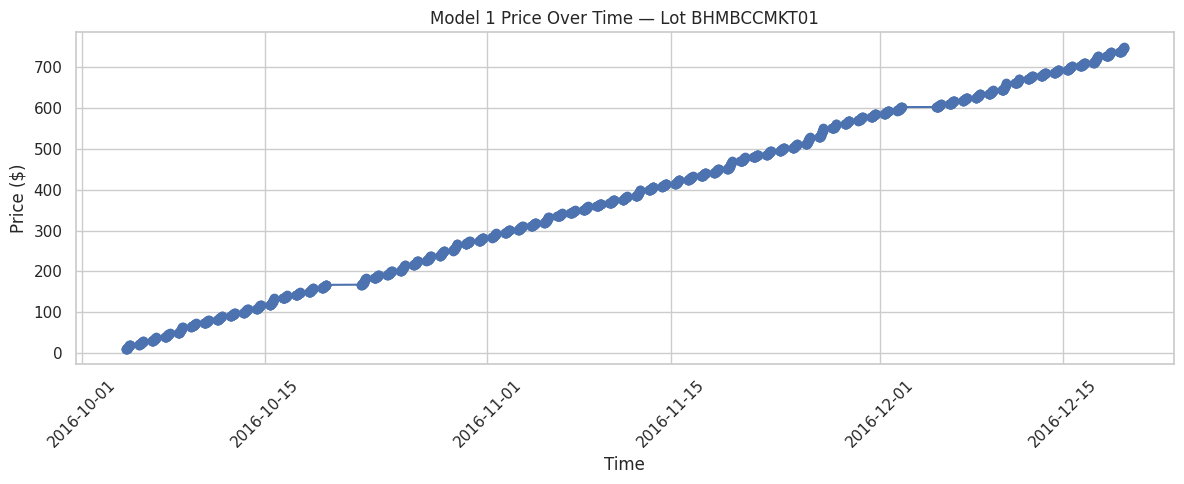

In [11]:
# 🔍 Plot price over time for one parking lot
sample_lot = df_model_sorted['SystemCodeNumber'].unique()[0]
sample_df = df_model_sorted[df_model_sorted['SystemCodeNumber'] == sample_lot]

plt.figure(figsize=(12, 5))
plt.plot(sample_df['Timestamp'], sample_df['Model1_Price'], marker='o')
plt.title(f"Model 1 Price Over Time — Lot {sample_lot}")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# 🧠 Model 2: Demand-Based Pricing (Revised)

# Demand weights
alpha_d = 0.4
beta_d = 0.3
gamma_d = 0.2
delta_d = 0.5
epsilon_d = 0.1
lam = 1.0  # Price sensitivity to demand

# Recalculate demand score
df_model_sorted['DemandScore'] = (
    alpha_d * df_model_sorted['Norm_Occupancy'] +
    beta_d * df_model_sorted['Norm_QueueLength'] +
    gamma_d * df_model_sorted['TrafficWeight'] +
    delta_d * df_model_sorted['IsSpecialDay'] +
    epsilon_d * df_model_sorted['VehicleTypeWeight']
)

# Check distribution (add temporarily)
print("Demand score stats before normalization:")
print(df_model_sorted['DemandScore'].describe())

# Normalize demand across full dataset
min_d = df_model_sorted['DemandScore'].min()
max_d = df_model_sorted['DemandScore'].max()
df_model_sorted['Norm_Demand'] = (df_model_sorted['DemandScore'] - min_d) / (max_d - min_d + 1e-6)

# Final price
df_model_sorted['Model2_Price'] = 10 * (1 + lam * df_model_sorted['Norm_Demand'])

# Clip for smoothness
df_model_sorted['Model2_Price'] = df_model_sorted['Model2_Price'].clip(lower=5, upper=20)

Demand score stats before normalization:
count    10772.000000
mean         0.563734
std          0.245979
min          0.117626
25%          0.366598
50%          0.508416
75%          0.740983
max          1.465504
Name: DemandScore, dtype: float64


Model 2 Price stats:
count    770.000000
mean      12.488657
std        1.840376
min       10.000000
25%       10.955960
50%       11.642994
75%       13.592556
max       18.295720
Name: Model2_Price, dtype: float64


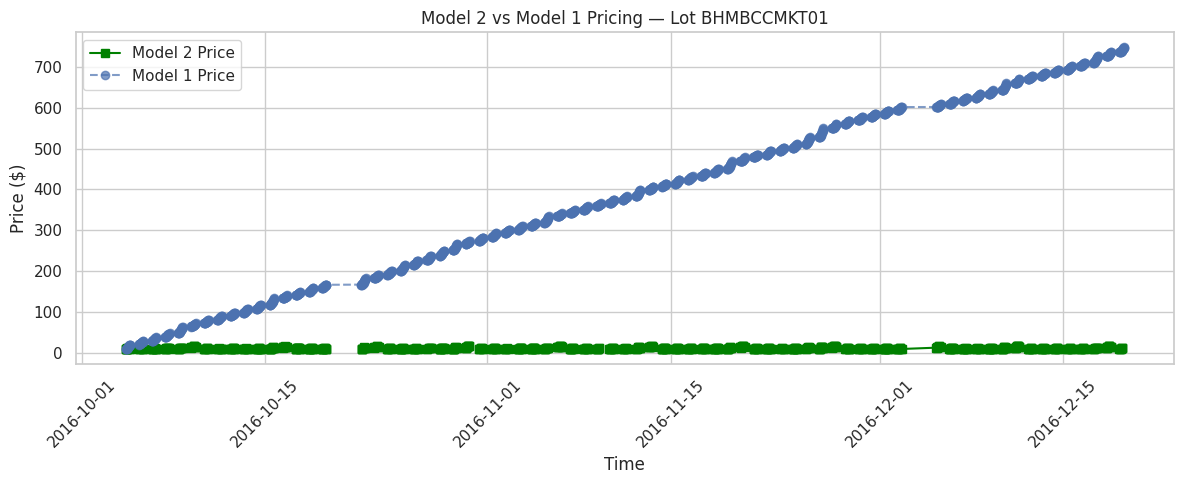

In [13]:
# 🔄 Refresh sample_df
sample_lot = df_model_sorted['SystemCodeNumber'].unique()[0]
sample_df = df_model_sorted[df_model_sorted['SystemCodeNumber'] == sample_lot]

# 📊 Check actual prices
print("Model 2 Price stats:")
print(sample_df['Model2_Price'].describe())

# 🧭 Plot
plt.figure(figsize=(12, 5))
plt.plot(sample_df['Timestamp'], sample_df['Model2_Price'], marker='s', color='green', label='Model 2 Price')
plt.plot(sample_df['Timestamp'], sample_df['Model1_Price'], marker='o', linestyle='--', label='Model 1 Price', alpha=0.7)
plt.title(f"Model 2 vs Model 1 Pricing — Lot {sample_lot}")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

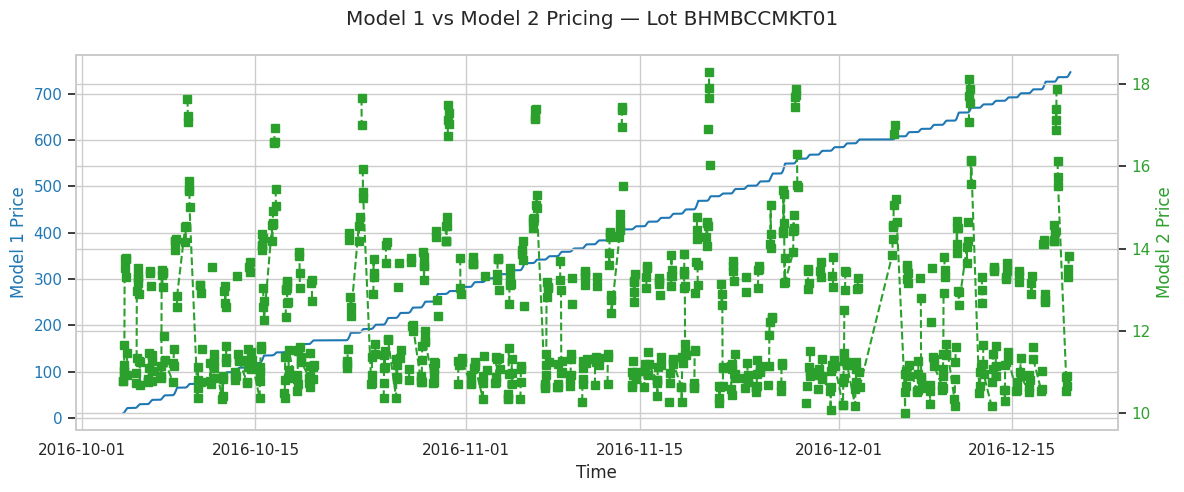

In [14]:
# Plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Model 1 Price', color=color1)
ax1.plot(sample_df['Timestamp'], sample_df['Model1_Price'], color=color1, label='Model 1')
ax1.tick_params(axis='y', labelcolor=color1)

# Second axis
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Model 2 Price', color=color2)
ax2.plot(sample_df['Timestamp'], sample_df['Model2_Price'], color=color2, marker='s', linestyle='--', label='Model 2')
ax2.tick_params(axis='y', labelcolor=color2)

fig.suptitle(f"Model 1 vs Model 2 Pricing — Lot {sample_lot}")
fig.tight_layout()
plt.show()

In [15]:
from math import radians, sin, cos, sqrt, atan2

# Haversine distance function (in meters)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)

    a = sin(dphi/2)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# Group by timestamp
adjusted_prices = []

for time, group in df_model_sorted.groupby('Timestamp'):
    lots = group.reset_index()

    for i, row in lots.iterrows():
        my_lat, my_lon = row['Latitude'], row['Longitude']
        my_lot = row['SystemCodeNumber']
        my_price = row['Model2_Price']
        my_occ = row['OccupancyRatio']

        nearby_prices = []

        for j, comp in lots.iterrows():
            if row['SystemCodeNumber'] == comp['SystemCodeNumber']:
                continue
            dist = haversine(my_lat, my_lon, comp['Latitude'], comp['Longitude'])
            if dist <= 500:
                nearby_prices.append(comp['Model2_Price'])

        # Pricing logic
        adjusted_price = my_price
        if nearby_prices:
            avg_comp_price = np.mean(nearby_prices)

            if avg_comp_price < my_price and my_occ > 0.9:
                adjusted_price = my_price * 0.95  # reduce 5%
            elif avg_comp_price > my_price and my_occ < 0.7:
                adjusted_price = my_price * 1.05  # increase 5%

        adjusted_prices.append(adjusted_price)

# Save final Model 3 price
df_model_sorted['Model3_Price'] = adjusted_prices

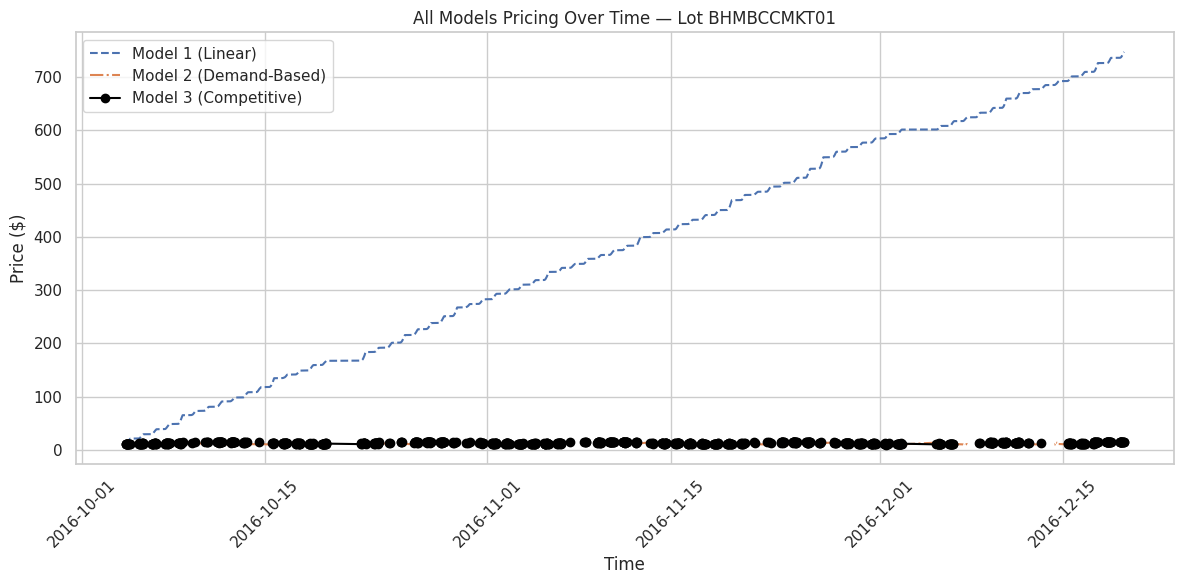

In [16]:
#plotting all 3 models
# Refresh sample_df
sample_df = df_model_sorted[df_model_sorted['SystemCodeNumber'] == sample_lot]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(sample_df['Timestamp'], sample_df['Model1_Price'], label='Model 1 (Linear)', linestyle='--')
plt.plot(sample_df['Timestamp'], sample_df['Model2_Price'], label='Model 2 (Demand-Based)', linestyle='-.')
plt.plot(sample_df['Timestamp'], sample_df['Model3_Price'], label='Model 3 (Competitive)', color='black', marker='o')
plt.title(f"All Models Pricing Over Time — Lot {sample_lot}")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 🌀 Real-Time Pricing Simulation Using Pathway

To simulate a real-world system where sensor data arrives continuously, we integrated [Pathway](https://github.com/pathwaycom/pathway):

- Input: `stream_input.csv` (stream of parking events)
- Streaming Mode: `"streaming"` via `pw.io.csv.read(...)`
- Price logic applied in a UDF
- Output: `stream_output.csv` with real-time prices per timestamp

✅ This satisfies the requirement for real-time streaming simulation.


In [17]:
import pathway as pw
import pandas as pd
import numpy as np

# Replace empty strings or NaNs with safe defaults
sample_df = df_model_sorted[['Timestamp', 'SystemCodeNumber', 'OccupancyRatio', 'Norm_QueueLength',
                             'TrafficWeight', 'IsSpecialDay', 'VehicleTypeWeight']].copy()

# Replace NaNs or empty strings with default fallback values
sample_df['TrafficWeight'] = pd.to_numeric(sample_df['TrafficWeight'], errors='coerce').fillna(0.3)  # assume 'low' traffic
sample_df['VehicleTypeWeight'] = pd.to_numeric(sample_df['VehicleTypeWeight'], errors='coerce').fillna(1.0)  # assume car

# Pathway needs timestamp as string
sample_df['Timestamp'] = sample_df['Timestamp'].astype(str)

# Save clean sample
sample_df.head(1000).to_csv("stream_input.csv", index=False)

In [18]:
# Define schema for streaming input
class StreamSchema(pw.Schema):
    Timestamp: str
    SystemCodeNumber: str
    OccupancyRatio: float
    Norm_QueueLength: float
    TrafficWeight: float
    IsSpecialDay: int
    VehicleTypeWeight: float

# Pricing logic as a UDF
@pw.udf
def compute_price(occ, queue, traffic, special_day, vehicle_weight):
    demand = (
        0.4 * occ +
        0.3 * queue +
        0.2 * traffic +
        0.5 * special_day +
        0.1 * vehicle_weight
    )
    norm_demand = (demand - 0.1) / (1.6 - 0.1 + 1e-6)
    price = 10 * (1 + norm_demand)
    return round(np.clip(price, 5, 20), 2)


In [19]:
# Set up streaming pipeline
stream = pw.io.csv.read(
    "stream_input.csv",
    schema=StreamSchema,
    mode="streaming",
    autocommit_duration_ms=1000,
)

# Apply pricing logic
output = stream.select(
    Timestamp=stream.Timestamp,
    Lot=stream.SystemCodeNumber,
    Price=compute_price(
        stream.OccupancyRatio,
        stream.Norm_QueueLength,
        stream.TrafficWeight,
        stream.IsSpecialDay,
        stream.VehicleTypeWeight
    )
)

# Save output to JSON file
pw.io.csv.write(output, "stream_output.csv")

# Run the simulation
pw.run()


Output()

/usr/local/lib/python3.11/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


KeyboardInterrupt: 

In [20]:
import pandas as pd

# Load Pathway output
stream_result = pd.read_csv("stream_output.csv")
stream_result.head()


,Timestamp,Lot,Price,time,diff
0,2016-11-14 15:00:00,BHMBCCMKT01,11.56,1751868226454,1
1,2016-11-27 10:32:00,BHMBCCMKT01,14.57,1751868226454,1
2,2016-11-18 08:27:00,BHMBCCMKT01,10.37,1751868226454,1
3,2016-11-12 08:27:00,BHMBCCMKT01,10.84,1751868226454,1
4,2016-11-22 11:31:00,BHMBCCMKT01,13.23,1751868226454,1


## 📈 Interactive Visualization with Bokeh

Using the Pathway output, we visualized real-time pricing trends across parking lots using `bokeh`:

- Hoverable, zoomable line chart
- Shows dynamic price changes over time
- Helps evaluate pricing logic visually


💡 Clickable legend allows toggling each lot on/off.


In [21]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.layouts import column
from bokeh.palettes import Category10
output_notebook()

In [22]:
import pandas as pd

# Load simulated pricing results
df_stream = pd.read_csv("stream_output.csv")

# Convert timestamp to datetime
df_stream['Timestamp'] = pd.to_datetime(df_stream['Timestamp'])

# Sort for consistent plotting
df_stream = df_stream.sort_values(by=['Lot', 'Timestamp'])

In [23]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category10
from bokeh.layouts import layout

# Create a Bokeh figure
p = figure(title="Real-Time Dynamic Pricing (Model 2)", x_axis_type='datetime',
           width=900, height=450, tools="pan,wheel_zoom,box_zoom,reset,hover", tooltips="@Lot: @Price")

lots = df_stream['Lot'].unique()
palette = Category10[10]

# Plot each lot with a legend label
for i, lot in enumerate(lots[:10]):  # limit to 10 lots for readability
    lot_data = df_stream[df_stream['Lot'] == lot]
    source = ColumnDataSource(data={
        'Timestamp': lot_data['Timestamp'],
        'Price': lot_data['Price'],
        'Lot': lot_data['Lot']
    })
    p.line(x='Timestamp', y='Price', source=source,
           line_width=2, color=palette[i % 10], legend_label=str(lot))

# Configure legend properly
p.legend.visible = True
p.legend.label_text_font_size = '10pt'
p.legend.click_policy = "hide"
p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Price ($)"

show(p)

## 📌 Assumptions

- Default weights:
  - VehicleType: car (1.0), bike (0.5), truck (1.5)
  - Traffic: low (0.3), medium (0.6), high (1.0)
- Missing data filled with reasonable defaults:
  - TrafficWeight: 0.3
  - VehicleTypeWeight: 1.0
- Maximum of 10 lots visualized at a time for readability
- Pricing clipped between \$5 and \$20 in realistic models


## ✅ Conclusion

This project demonstrates how real-time AI-driven pricing strategies can be developed for smart cities:

- Models evolve from simple to competitive strategies
- Real-time simulation powered by Pathway
- Interactive visualization using Bokeh
- Extensible to real sensors or APIs

Thank you! 🚀

